In [1]:
import requests
import os
import logging
import gdown
import random

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import VOCSegmentation
import torchmetrics
import torchvision
import albumentations as A

import re
import string
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import cv2
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.io import loadmat
from sklearn.manifold import TSNE
from torchmetrics.classification import MulticlassF1Score, JaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassAveragePrecision
import pandas as pd
from torchinfo import torchinfo

from transformers import ConvNextV2Model, BertModel, BertTokenizer, ViTModel, ViTConfig
from transformers import AutoTokenizer, AutoModel, RobertaTokenizer, CLIPModel, CLIPTokenizer, CLIPProcessor
from transformers import DeiTConfig, DeiTFeatureExtractor, DeiTImageProcessor, DeiTModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import timm
from transformers import AlignModel, AlignProcessor, AlignConfig, AlignVisionConfig, AlignTextConfig
from transformers import CLIPModel, CLIPProcessor, CLIPConfig, CLIPTextConfig, CLIPVisionConfig, CLIPImageProcessor

from torchmetrics.functional import pairwise_cosine_similarity
from torchmetrics.classification import MultilabelAccuracy
from transformers import AutoImageProcessor, Swinv2Model

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
logging.basicConfig(level=logging.ERROR)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")




There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3090


In [3]:
ROOT_DIR = '../Datasets/ocular-disease-recognition-odir5k/'

## DeiT

In [4]:
BATCH_SIZE = 16

In [5]:
CSV_PATH = ROOT_DIR + 'dataset_single_eye.csv'
TEST_CSV = ROOT_DIR + 'TESTING_dataset_single_eye.csv'
IMG_PATH = ROOT_DIR + 'preprocessed_histeq_images/'

In [6]:
torchvision.io.read_image(IMG_PATH + '0_left.jpg').shape

torch.Size([1, 512, 512])

In [7]:
train_val_df = pd.read_csv(CSV_PATH)
test_df = pd.read_csv(TEST_CSV)

In [8]:
def preprocess_text(df:pd.DataFrame):
    df['Keywords'] = df['Keywords'].str.lower()
    df['Keywords'] = df['Keywords'].apply(lambda x: " ".join(x.split()))
    df['Keywords'] = df['Keywords'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
    return df
train_val_df = preprocess_text(train_val_df)
test_df = preprocess_text(test_df)

In [9]:
train_val_df['Patient Sex'] = train_val_df['Patient Sex'].astype('category').cat.codes
test_df['Patient Sex'] = test_df['Patient Sex'].astype('category').cat.codes

train_val_df['eye'] = train_val_df['Patient Sex'].astype('category').cat.codes
test_df['eye'] = test_df['Patient Sex'].astype('category').cat.codes

In [10]:
train_val_df

,ID,Patient Age,Patient Sex,Image,Keywords,eye,N,D,G,C,A,H,M,O,NOT DECISIVE
0,970,56,0,970_right.jpg,cataract,0,0,0,0,1,0,0,0,0,0
1,127,52,1,127_left.jpg,proliferative diabetic retinopathy，hypertensiv...,1,0,1,0,0,0,0,0,0,0
2,850,68,1,850_right.jpg,macular epiretinal membrane，moderate non proli...,1,0,1,0,0,0,0,0,0,0
3,37,41,1,37_right.jpg,normal fundus,1,1,0,0,0,0,0,0,0,0
4,4421,59,1,4421_right.jpg,moderate non proliferative retinopathy,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,199,50,0,199_left.jpg,branch retinal vein occlusion,0,0,0,0,0,0,0,0,1,0
5734,516,42,1,516_right.jpg,moderate non proliferative retinopathy,1,0,1,0,0,0,0,0,0,0
5735,4603,47,0,4603_left.jpg,severe nonproliferative retinopathy,0,0,1,0,0,0,0,0,0,0
5736,2132,59,0,2132_right.jpg,normal fundus,0,1,0,0,0,0,0,0,0,0


In [11]:
np.max(train_val_df['Keywords'].apply(lambda x: len(x.split())))

10

In [12]:
train_df, val_df = train_test_split(train_val_df, test_size = 0.15, random_state= 123456)
len(train_df), len(val_df)

(4877, 861)

In [13]:
IMG_SIZE = (224, 224)

rescale_transform = torchvision.transforms.Compose([
    #torchvision.transforms.CenterCrop(IMG_SIZE),
    torchvision.transforms.Resize(IMG_SIZE, antialias = False, interpolation = torchvision.transforms.InterpolationMode.NEAREST),
    torchvision.transforms.Normalize(
        timm.data.constants.IMAGENET_DEFAULT_MEAN,
        timm.data.constants.IMAGENET_DEFAULT_STD
    )
])

augmentation = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Resize(IMG_SIZE, antialias = False, interpolation = torchvision.transforms.InterpolationMode.NEAREST),
#     torchvision.transforms.RandomHorizontalFlip(p = 0.5),
#     torchvision.transforms.RandomVerticalFlip(p= 0.5),
    #torchvision.transforms.RandomRotation(90)
])

In [14]:
np.c_[train_val_df['Patient Age'].to_numpy(), train_val_df['Patient Sex'].to_numpy()]

array([[56,  0],
       [52,  1],
       [68,  1],
       ...,
       [47,  0],
       [59,  0],
       [55,  0]], dtype=int64)

In [40]:
class ODIRDataset(Dataset) :
    def __init__(self, df, IMG_FOLDER, extractor = rescale_transform, augmentation = None) :
        '''
        id : list of samples ids as string
        '''
        #self.text = [tokenizer(text = x, padding = 'max_length', max_length = 40, truncation = True, return_tensors = 'pt') for x in df['Keywords']]
        self.images = [Image.open(IMG_PATH + x).convert("RGB") for x in df['Image']]   #'''.convert("RGB")''' 
        processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.images = [processor(x, return_tensors="pt") for x in self.images]
        sex = df['Patient Age'].to_numpy()
        age = (df['Patient Age']/df['Patient Age'].max()).to_numpy()
        self.feats = torch.tensor(np.c_[sex, age], requires_grad= True)
        self.labels = torch.tensor(df[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].to_numpy()).float()
        self.img_dir = [IMG_PATH + x for x in df['Image']]

        self.augmentation = augmentation

#         self.images = [extractor(torchvision.io.read_image(x)/255.0) for x in self.img_dir]
        #self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        batch_imgs = self.images[idx]
#         if(self.augmentation is not None):
#             batch_imgs = self.augmentation(batch_imgs)
        return batch_imgs, self.feats[idx], self.labels[idx]

In [41]:
train_dataset = ODIRDataset(train_df, IMG_PATH, augmentation = augmentation)
val_dataset   = ODIRDataset(val_df, IMG_PATH)
test_dataset  = ODIRDataset(test_df, IMG_PATH)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ValueError: Unsupported number of image dimensions: 2

In [ ]:
with open("datasets.trch", 'wb') as f:
    torch.save([train_dataset, val_dataset, test_dataset], f)

In [ ]:
with open("datasets.trch", 'rb') as f:
    train_dataset, val_dataset, test_dataset = torch.load(f)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size= BATCH_SIZE)

In [18]:
# contrastive learning on training data finetuning

In [19]:

#odict_keys(['loss', 'logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

In [20]:
class ClassificationNet(nn.Module):
    def __init__(self, dims = 768, drop_prob = 0.5):
        super().__init__()
        self.layer_1 = nn.Linear(dims, 768)
        self.layer_2 = nn.Linear(768, 768)
        self.layer_3 = nn.Linear(768, dims)
        
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, input):
        resi = input
        out = self.dropout(input)
        out = F.relu(self.layer_1(out))
        out = self.dropout(out)
        out = F.relu(self.layer_2(out))
        out = self.dropout(out)
        out = F.relu(self.layer_3(out))
        out = out + resi
        return out


In [21]:
# m = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

# list(m.children())[-4:-1]

# torchinfo.summary(m, (5, 3, 224, 224))

In [22]:
class DeiT(nn.Module):
    def __init__(self):
        super().__init__()
#         self.base = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
#         self.base.reset_classifier(8)
        self.base = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.base.pooler = nn.AdaptiveAvgPool1d(output_size=1)
        self.img_net = ClassificationNet(dims = 512, drop_prob=0.5)
        self.img_head = nn.Linear(770, 8)
    
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, pixel_values, add_info):
        pixel_values = pixel_values['pixel_values']
        pixel_values = pixel_values.squeeze(1)
        out = self.base(pixel_values)
        out = out['pooler_output']
        out = torch.hstack([out, add_info])
        out = self.img_head(out)
        out = F.sigmoid(out)
        return out#, img_outs, txt_outs

In [23]:
model= DeiT().to(device)

Some weights of the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 were not used when initializing Swinv2Model: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing Swinv2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Swinv2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=4, verbose=True)

In [27]:
torch.cuda.empty_cache()
weights = torch.tensor([0.5, 1., 1.25, 1.25, 1.25, 1.3, 1.25, .9]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
train_img_acc = MultilabelAccuracy(8, average = 'micro').to(device)
val_img_acc = MultilabelAccuracy(8, average = 'micro').to(device)

img_loss_fn = nn.BCELoss(weights)

EPOCHS = 10

for epoch_num in range(EPOCHS):

  total_acc_train = 0
  total_loss_train = 0

  for train_image, train_metadata, train_label in tqdm(train_dataloader):
        optimizer.zero_grad()
        train_label = train_label.to(device)
        train_image = train_image.to(device)

        train_metadata = train_metadata.to(device).float()

        output = model(train_image, train_metadata)

        batch_loss = img_loss_fn(output, train_label)
        batch_loss.backward()
        optimizer.step()
        total_loss_train += batch_loss.item()
      
        train_img_acc(output, train_label)

  total_loss_val = 0

  with torch.no_grad():
      #Validation
      for val_image, val_metadata, val_label in val_dataloader:
        optimizer.zero_grad()
        val_label = val_label.to(device)
        val_image = val_image.to(device)
        val_metadata = val_metadata.to(device).float()
      

        output = model(val_image, val_metadata)

        batch_loss = img_loss_fn(output, val_label)
        total_loss_val += batch_loss.item()
        val_img_acc(output, val_label)
              
      
  avg_train_loss = total_loss_train/len(train_df)

  avg_val_loss = total_loss_val/len(val_df)


  print("Epoch [{}/{}], Train Loss: {:.4f}, acc img: {:.4f}".format(epoch_num+1, EPOCHS, avg_train_loss*BATCH_SIZE, train_img_acc.compute()))
  print("Epoch [{}/{}], Val Loss: {:.4f}, acc img: {:.4f}".format(epoch_num+1, EPOCHS, avg_val_loss*BATCH_SIZE, val_img_acc.compute()))
  early_stopping(avg_val_loss, model)

  if early_stopping.early_stop:
      print("Early stopping")
      print('-'*60)
      break
  train_img_acc.reset()
  val_img_acc.reset()

  torch.save(model.state_dict(), './' + 'checkpoint_deit' + '.pt' )

torch.save(model.state_dict(), './' + 'finetuned_deit' + '.pt' )


  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

c:\ProgramData\Anaconda3\envs\torchnew\Lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric MultilabelAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Epoch [1/10], Train Loss: 0.0000, acc img: 0.0000
Epoch [1/10], Val Loss: 0.5762, acc img: 0.7114
Validation loss decreased (inf --> 0.036015).  Saving model ...


  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

  0%|          | 0/305 [00:00<?, ?it/s]


{'pixel_values': tensor([[[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]

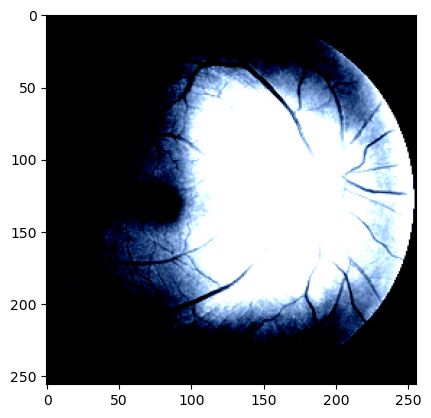

In [37]:
plt.imshow(train_image['pixel_values'][0][0].permute(1, 2, 0).detach().cpu().numpy(), cmap = 'gray')

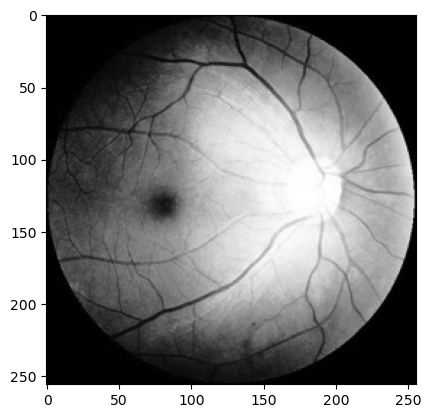

In [68]:
plt.imshow(train_image['pixel_values'][0][0].permute(1, 2, 0)[:, :, 0].detach().cpu().numpy(), 'gray')

In [ ]:
with open("checkpoint.pt", 'rb') as f:
    model.load_state_dict(torch.load(f))

## Evaluation on test set

In [ ]:
#criterion = nn.BCELoss(torch.tensor([0.5, 1, 5, 5, 5, 6, 5, 1]).float().to(device))

test_loss = 0
test_acc  = 0

AVERAGING = 'micro'
PREC = torchmetrics.classification.MultilabelPrecision(8, average = AVERAGING).to(device)#, validate_args = False)
ACC = torchmetrics.classification.MultilabelAccuracy(8, average = AVERAGING).to(device)#, validate_args = False)
REC = torchmetrics.classification.MultilabelRecall(8, average = AVERAGING).to(device)#, validate_args = False)
F1_SCORE = torchmetrics.classification.MultilabelF1Score(8, average = AVERAGING).to(device)#, validate_args = False)
F_BETA_SCORE = torchmetrics.classification.MultilabelFBetaScore(beta = 0.8, num_classes = 8, num_labels = 8, average = AVERAGING).to(device)#, validate_args = False)
KAPPA = torchmetrics.classification.MulticlassCohenKappa(8).to(device)#, validate_args = False)
AUC = torchmetrics.classification.MultilabelAUROC(8, average = AVERAGING).to(device)#, validate_args = False)

for train_image, train_metadata, train_label in tqdm(test_dataloader): 
    with torch.no_grad():
        optimizer.zero_grad()
        train_label = train_label.to(device)
        train_image = train_image.to(device)
        train_metadata = train_metadata.to(device).float()
      

        predictions = model(train_image, train_metadata)


        train_label = train_label.long()
        PREC(predictions, train_label)
        ACC(predictions, train_label)
        REC(predictions, train_label)
        F1_SCORE(predictions, train_label)
        F_BETA_SCORE(predictions, train_label)
        KAPPA(predictions, train_label)
        AUC(predictions, train_label)


add_prec = PREC.compute()
add_acc = ACC.compute()
add_rec = REC.compute()
add_f1 = F1_SCORE.compute()
add_fbeta = F_BETA_SCORE.compute()
add_kappa = KAPPA.compute()
add_auc = AUC.compute()

avg_test_loss = test_loss/len(test_df)*BATCH_SIZE
avg_test_acc  = test_acc /len(test_df)

print("Acc: {:3f}\nPrec: {:3f}\nRecall: {:.3f}\nF1-score: {:.3f}\nF-Beta-score: {:.3f}\nKappa: {:.3f}\nAUC: {:.3f}".format(add_acc, add_prec,add_rec, add_f1, add_fbeta, add_kappa, add_auc))
torch.cuda.empty_cache()

100%|██████████| 40/40 [00:04<00:00,  8.84it/s]

Acc: 0.916144
Prec: 0.714286
Recall: 0.549
F1-score: 0.621
F-Beta-score: 0.639
Kappa: 0.000
AUC: 0.929


In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-3]))
model

In [ ]:
from torchsummary import summary
model = model.to(device)
summary(model, input_size=(3, 224, 224))

In [ ]:

import torch
from datasets import load_dataset

# dataset = load_dataset("huggingface/cats-image")
# image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

# inputs = image_processor(image, return_tensors="pt")

# with torch.no_grad():
#     outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state
# list(last_hidden_states.shape)

In [ ]:
model.pooler = nn.AdaptiveAvgPool1d(output_size=8)
model

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.reset_classifier(8)
model

In [ ]:
torch.cuda.empty_cache()